In [1]:
from ExcitonBSEKeldysh import ExcitonMoS2
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import numba
from scipy.special import struve
from scipy.special import yn
from tqdm import tqdm
%matplotlib inline

## Solve optical exciton problem 

In [2]:
Exciton=ExcitonMoS2(epsilon=2.5,N=30,vb=[6],cb=[7],spin_orbit=False)
Exciton.constuctExcitonHamiltonian(Q=[0,0,0])
Exciton.solveExcitonHamiltonian(save=False)

## Parameters

In [3]:
NS=8 #Number of exciton states
norm=0.9 #Norm of exciton wave function

## Recalculate exciton wave function

In [4]:
N=Exciton.N;norb=Exciton.norb;
D=Exciton.DH.reshape((N,N,Exciton.nc,Exciton.nv,Exciton.NH))
D=D.transpose((4,0,1,2,3))
DH=np.zeros((NS,N,N,norb,norb),dtype=np.complex)
for s in tqdm(range(NS)):
    for i,c in enumerate(Exciton.cb):
        for j,v in enumerate(Exciton.vb):
            DH[s]+=D[s,:,:,None,None,i,j]*Exciton.D[:,:,:,None,v].conj()*Exciton.D[:,:,None,:,c]
D=np.abs(D.sum(axis=(3,4)).reshape(Exciton.NH,N**2))**2
DH=DH.reshape((NS,N**2,norb,norb))

100%|██████████| 8/8 [00:00<00:00, 533.05it/s]


## Sampling points in BZ according to norm of exciton wave function

In [5]:
points_array=[];indexes_array=[]
for s in tqdm(range(NS)):
    M=0.;points=[];indexes=[]
    while True:
        while True:
            i=np.random.randint(D[s].size)
            p=np.max(D[s])*np.random.random()
            if p<D[s,i]:
                break
        point=(i//N,i%N)
        if point not in points:
            points.append(point)
            indexes.append(i)
            M+=D[s,i]
        if M>norm:
            break
    indexes_array.append(np.array(indexes))
    points_array.append(np.array(points))

100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


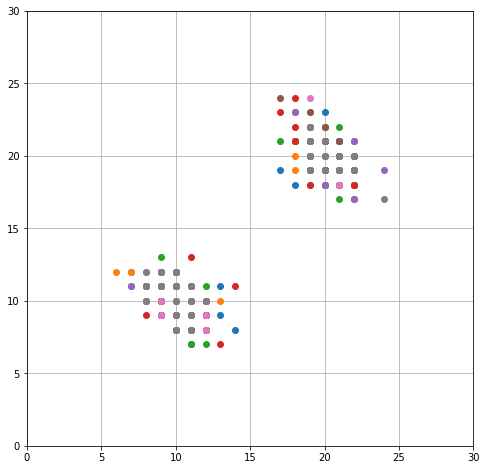

In [6]:
plt.figure(figsize=(8,8))
for s in range(NS):
    plt.plot(points_array[s][:,0],points_array[s][:,1],'o')
    plt.xlim([0,N])
    plt.ylim([0,N])
plt.grid()

## Generate coloumb interaction matrix W for four-point calculation

In [7]:
x,y=np.meshgrid(np.arange(N),np.arange(N))
X=np.empty((N,N,N,N),dtype=np.int);Y=np.empty((N,N,N,N),dtype=np.int)
for i,j in product(range(N),range(N)):
    X[i,j]=(x+i)%N
    Y[i,j]=(y+j)%N
W=Exciton.W.real[X,Y]

## Calculate matrix element of interaction of exciton

In [8]:
def matrix_element(indx,points_array,indexes_array,W,DH):
    M=[points_array[s].shape[0] for s in indx]
    # Generate coloumb matrix for reduced numbers of points in BZ 
    W_Full=np.empty(M)
    for i0 in range(M[0]):
        kx0=points_array[indx[0]][i0,0]
        ky0=points_array[indx[0]][i0,1]
        for i1 in range(M[1]):
            kx1=points_array[indx[1]][i1,0]
            ky1=points_array[indx[1]][i1,1]
            for i2 in range(M[2]):
                kx2=points_array[indx[2]][i2,0]
                ky2=points_array[indx[2]][i2,1]
                for i3 in range(M[3]):
                    kx3=points_array[indx[3]][i3,0]
                    ky3=points_array[indx[3]][i3,1]
                    W_Full[i0,i1,i2,i3]=W[(kx1-kx2)%N,(ky1-ky2)%N,(kx0-kx3)%N,(ky0-ky3)%N]
    # Generate exciton wave functions for reduced number of points in BZ 
    A0=DH[indx[0],indexes_array[indx[0]]].conj()
    A1=DH[indx[1],indexes_array[indx[1]]].conj()
    A2=DH[indx[2],indexes_array[indx[2]]]
    A3=DH[indx[3],indexes_array[indx[3]]]
    # Calculate direct matrix element
    result =2*np.einsum('abcd,aij,bkl,cij,dkl',W_Full,A0,A1,A2,A3,casting='same_kind',optimize='optimal')
    # Calculate exchange matrix element
    result-=2*np.einsum('abcd,aij,bkl,cil,dkj',W_Full,A0,A1,A2,A3,casting='same_kind',optimize='optimal')
    return result

In [9]:
%%time
matrix_element([0,0,0,0],points_array,indexes_array,W,DH)

CPU times: user 6.4 s, sys: 333 ms, total: 6.73 s
Wall time: 3.61 s


(0.00012008299695048796-1.5809371668192984e-17j)

In [ ]:
import multiprocessing
from functools import partial
pool = multiprocessing.Pool(8)
indexes=[[i0,i1,i2,i3] for i0,i1,i2,i3 in product(range(NS),range(NS),range(NS),range(NS))]
result=pool.map(partial(matrix_element,points_array=points_array,indexes_array=indexes_array,W=W,DH=DH), indexes)
result=np.array(result).reshape((NS,NS,NS,NS))

In [ ]:
np.save('result',result)

# Exciton Band Structure

In [ ]:
N=Exciton.N
Q=[];k=0
indx=np.zeros((N,N),dtype=np.int)
for i in range(N):
    for j in range(np.min([i+1,N-i+1])):
        Q.append([i,j,0])
        indx[i,j]=k;indx[-i,-j]=k;
        indx[j,i]=k;indx[-j,-i]=k
        k+=1
EX=np.empty((len(Q),Exciton.NH))
DX=np.empty((len(Q),Exciton.NH,Exciton.NH),dtype=np.complex)
for k in tqdm(range(len(Q))):
    Exciton.constuctExcitonHamiltonian(Q=Q[k])
    Exciton.solveExcitonHamiltonian(save=False)
    EX[k]=Exciton.EH;DX[k]=Exciton.DH

In [ ]:
E=EX[indx]
plt.figure(figsize=(12,8))
plt.contourf((Exciton.K[:,:,0]-2.29565808/2),(Exciton.K[:,:,1]-2.29565808/2),np.fft.fftshift(E[:,:,0]),cmap='jet')#,marker='h',s=120)
plt.axis('equal')
plt.colorbar()